In [ ]:
#| default_exp phononsmatrix

# Phonon Transport at Interfaces 

>using the reasearch paper on  Phonon transport at interfaces: [Determining the correct modes of vibration](https://bpb-us-e1.wpmucdn.com/sites.mit.edu/dist/6/1786/files/2019/10/2015-Phonon-Transport-at-Interfaces-Determining-the-Correct-Modes-of-Vibration.pdf) published by Kiarash Gordiz, and Asegun Henry

### 1. Introduction
In solids, atoms are not perfectly still; they vibrate. These vibrations carry heat, much like data packets travel across a network. At ann interface(boundary between two materials), the way vibrations pass through dertermines how well heat flows. 

Our goal: simulate this "vibration transport" using only linear algebra and Python- no advanced physics background needed.

### 2. Equations of Motion -> Matrix Form
Imagine each atom is a point mass attached to its neighbours by springs.
The physics law is just newtons second law:
$M\ddot{u}(t) = -K u(t)$.
* M : diagonal matrix of atomic masses
* K : stiffness (spring constant) matrix
* u(t) : displacement vector (positions)

this is just like solving a second-order system of ODEs. 
Instead of time-stepping, we assume vibrations oscillate like  $u(t) = U e^{-i \omega t}$
and reduce the ODE to an eigenvalue problem  $\big( K - \omega^2 M \big) U = 0$

This tells us the frequencies $\omega$ (the signal frequencies) and shapes $U$ (like signal modes).

### 3. The interface problem 
* Think of a chain of atoms: left half are "Material A", right half are "Material B".
* They are joined in the middle -> the interface.
* Each material supports certain vibration patterns("phonons").
* At the interface, do vibrations transmit or reflect?

This is what we want to compute.

### 4. Lattice Dynamics + Green's Functions

We use a standard trick: 
* Transform the equations into frequency domain.
* Replace solving Ordinary differential equations with matrix inversion.

The central object is the Green's function:
$$
G(\omega) = \Big[ \, (\omega^2 + i\eta) I - D - \Sigma_L(\omega) - \Sigma_R(\omega) \, \Big]^{-1}
$$

Where:  

- $D = M^{-1/2} K M^{-1/2}$ is the **mass-normalized dynamical matrix**  
- $\Sigma_L, \Sigma_R$ are the **self-energies** of the left/right leads  
- $i\eta$ is a small numerical damping term (keeps the matrix invertible)  

---

### Transmission Function

Once $G(\omega)$ is known, the phonon transmission is:

$$
T(\omega) = \mathrm{Tr} \Big[ \, \Gamma_L \, G \, \Gamma_R \, G^\dagger \, \Big]
$$

where

$$
\Gamma = i \, \big( \Sigma - \Sigma^\dagger \big)
$$


### 5. Implementing in Python
First, lets set up a toy 1D model with two materials. Each atom is a mass, each bond a spring. 

In [ ]:
#| export
import numpy as np 
from numpy.linalg import inv, eig
from scipy.linalg import eigh

Build the device region: 8 atoms in a chain. Left half: light atoms with strong springs. Right half: heavy atoms with weak springs.

In [ ]:
#| export
# Left material
mL, kL = 1.0, 1.0
# Right material
mR, kR = 2.0, 0.6
N = 8
m = np.array([mL]*(N//2) + [mR]*(N - N //2))

### 5a) Mass matrix and mass-normalized dynamical matrix \(D\)

We convert the force-constant matrix \(K\) into the **mass-normalized** dynamical matrix

$$
D \;=\; M^{-1/2}\, K\, M^{-1/2},
$$

where $M=\mathrm{diag}(m_1,\dots,m_N)$ comes from the per-atom masses.  
This converts $(K-\omega^2 M)U=0$ into a standard eigenproblem $D U=\omega^2 U$.


In [ ]:
#| export
def device_force_constants(N: int, k_left: float, k_right: float) -> np.ndarray:
    """
    Build the NxN force-constant (Hessian) matrix K for a 1D chain with an interface.
    - First half bonds use k_left
    - Second half bonds use k_right
    Nearest-neighbor springs only (tridiagonal K).
    """
    K = np.zeros((N, N), dtype=float)

    for i in range(N):
        # left bond (i-1 <-> i)
        if i > 0:
            kij = k_left if (i - 1) < (N // 2) else k_right
            K[i, i]   += kij
            K[i, i-1] -= kij

        # right bond (i <-> i+1)
        if i < N - 1:
            kij = k_left if i < (N // 2) else k_right
            K[i, i]   += kij
            K[i, i+1] -= kij

    return K


In [ ]:
#| export
K_dev = device_force_constants(N, kL, kR)

#Mass-normalize: D = $M^{-1/2} K M^{-1/2}$
Minv_sqrt = np.diag(1.0 / np.sqrt(m))
D_dev = Minv_sqrt @ K_dev @ Minv_sqrt
D_dev

array([[ 1.        , -1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.        ,  2.        , -1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        , -1.        ,  2.        , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  2.        , -0.70710678,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.70710678,  0.8       ,
        -0.3       ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.3       ,
         0.6       , -0.3       ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.3       ,  0.6       , -0.3       ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.3       ,  0.3       ]])

### 6) Leads and surface Green’s functions (Sancho–Rubio)

We treat the left/right **semi-infinite** materials (“leads”) via their **surface Green’s functions$$ g_L, g_R$$
For a 1D monatomic chain (1 DOF per cell), the mass-normalized on-site and coupling blocks are

$$
H_0 = \frac{2k}{m}, \qquad H_1 = -\frac{k}{m}.
$$

We compute the surface Green’s function using the **Sancho–Rubio decimation** (a fixed-point block-matrix iteration).


In [ ]:
#| export
from numpy.linalg import inv

def lead_blocks(mass: float, kspring: float):
    h0 = 2.0 * kspring / mass
    h1 = -1.0 * kspring / mass
    H0 = np.array([[h0]], dtype=float)
    H1 = np.array([[h1]], dtype=float)
    return H0, H1

def sancho_rubio(H0: np.ndarray, H1: np.ndarray, w2: float, eta: float = 1e-12, max_iter: int = 200):
    """Surface Green's function g^r for a semi-infinite 1D chain (1x1 blocks)."""
    z = w2 + 1j*eta
    a = H0.copy()
    b = H1.copy()
    for _ in range(max_iter):
        g = inv(z*np.eye(a.shape[0]) - a)
        a_new = a + b @ g @ b.T
        b_new = b @ g @ b
        if np.allclose(a_new, a) and np.allclose(b_new, b):
            a, b = a_new, b_new
            break
        a, b = a_new, b_new
    gsurf = inv(z*np.eye(a.shape[0]) - a)
    return gsurf

# Build left/right lead blocks
H0L, H1L = lead_blocks(mL, kL)
H0R, H1R = lead_blocks(mR, kR)

def surface_g_mono(w: float, m: float, k: float, eta: float = 1e-6) -> np.ndarray:
    """
    Retarded surface Green's function g^r(ω) for a semi-infinite 1D monatomic chain
    in the *mass-normalized* basis.

    Chain blocks: H0 = 2k/m, H1 = -k/m (scalar).
    g satisfies: (h1^2) g^2 - (z - h0) g + 1 = 0,  z=ω^2+iη.
    Pick the root with Im(g) < 0 (retarded condition).
    """
    z  = w**2 + 1j*eta
    h0 = 2.0 * k / m
    h1 = -1.0 * k / m
    a  = z - h0
    b2 = h1 * h1

    # complex-safe sqrt
    root = np.lib.scimath.sqrt(a*a - 4.0*b2)
    g1 = (a - root) / (2.0*b2)
    g2 = (a + root) / (2.0*b2)

    g = g1 if np.imag(g1) < 0 else g2  # retarded: Im(g) < 0
    return np.array([[g]], dtype=complex)


### 7) Self-energies, device Green’s function, and transmission

Couple the device’s end atoms to the leads. In the mass-normalized basis, the coupling vectors are

$$
V_L[0]=-\sqrt{k_L/m_L}, \quad V_R[-1]=-\sqrt{k_R/m_R}.
$$

Then compute:
- Lead self-energies $\Sigma_{L,R} = V_{L,R}\, g_{L,R}\, V_{L,R}^T$
- Broadening matrices $\Gamma = i(\Sigma - \Sigma^\dagger)$
- Device Green’s function $G = \big[(\omega^2+i\eta)I - D - \Sigma_L - \Sigma_R\big]^{-1}$
- Transmission $T(\omega) = \mathrm{Tr}\big[\Gamma_L\, G\, \Gamma_R\, G^\dagger\big]$


In [ ]:
#| export
def gamma_from_sigma(Sigma: np.ndarray) -> np.ndarray:
    return 1j * (Sigma - Sigma.conj().T)

# Coupling vectors in mass-normalized basis
VL = np.zeros((N, 1)); VL[0, 0]  = -np.sqrt(kL / mL)
VR = np.zeros((N, 1)); VR[-1, 0] = -np.sqrt(kR / mR)

def transmission_at(w: float, eta: float = 1e-6):
    # 1x1 surface GFs via closed-form
    gL = surface_g_mono(w, mL, kL, eta=eta)
    gR = surface_g_mono(w, mR, kR, eta=eta)

    SigmaL = VL @ gL @ VL.T
    SigmaR = VR @ gR @ VR.T

    GammaL = 1j * (SigmaL - SigmaL.conj().T)
    GammaR = 1j * (SigmaR - SigmaR.conj().T)

    z = (w**2 + 1j*eta)
    G = np.linalg.inv(z*np.eye(N) - D_dev - SigmaL - SigmaR)

    T = np.real(np.trace(GammaL @ G @ GammaR @ G.conj().T))
    return float(T), G, SigmaL, SigmaR



### 8) Frequency sweep and plot $T(\omega)$

We scan $ \omega\ $ and visualize the transmission spectrum.


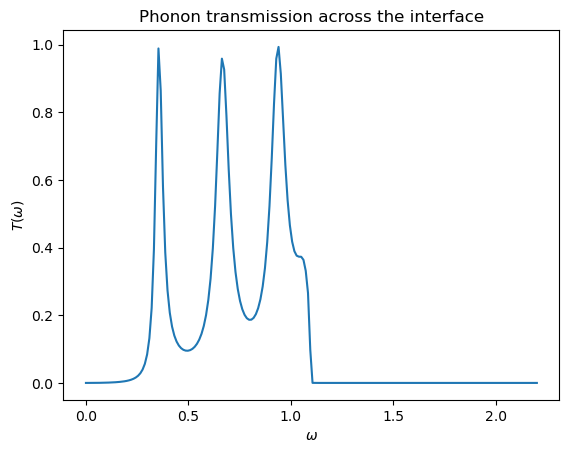

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt

ws = np.linspace(0.0, 2.2, 200)
Ts = [transmission_at(w)[0] for w in ws]

plt.figure()
plt.plot(ws, Ts)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$T(\omega)$')
plt.title('Phonon transmission across the interface')
plt.show()


### 9) System eigenmodes (the Gordiz–Henry “correct modes”)

Diagonalize the **device’s** dynamical matrix \(D\) to obtain eigenpairs
$(\omega_n^2, U_n)$.  
These are the **system modes** spanning the interface region (not bulk modes).  
They provide a physically correct basis to interpret which patterns couple to the leads.

A quick heuristic: modes with larger amplitude on the end atoms couple better to the leads.


In [ ]:
#| export
from scipy.linalg import eigh

w2_vals, U = eigh(D_dev)                     # D U = U diag(w^2)
w_vals = np.sqrt(np.clip(w2_vals, 0, None))  # frequencies

# Heuristic coupling measure: weight on the two boundary atoms
end_coupling_weight = (U[0, :]**2 + U[-1, :]**2)

# Peek at the first few modes (frequency and end-coupling weight)
list(zip(w_vals[:5].round(4), end_coupling_weight[:5].round(4)))


[(np.float64(0.0), np.float64(0.25)),
 (np.float64(0.2867), np.float64(0.4894)),
 (np.float64(0.5418), np.float64(0.4146)),
 (np.float64(0.7725), np.float64(0.291)),
 (np.float64(0.989), np.float64(0.1394))]

### 10) (Optional) Spectral channels via the spectral function

For deeper mode analysis, compute the **spectral function** $ A(\omega)=i(G-G^\dagger) $
and diagonalize it to get frequency-resolved **transport channels**.


In [ ]:
#| export
def spectral_channels(G: np.ndarray):
    A = 1j * (G - G.conj().T)
    # Hermitian stabilization for numerical safety
    A_herm = 0.5 * (A + A.conj().T)
    evals, evecs = eigh(A_herm)
    return evals, evecs, A
